In [1]:
import sys
from math import sqrt
import numpy as np
from numpy import array

from scipy.signal import savgol_filter

from sklearn.metrics import mean_squared_error

import pandas as pd

from matplotlib import pyplot

import tensorflow as tf

from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense

from keras.models import Sequential

from gcd_data_manipulation import data_aggregation
from gcd_data_manipulation import load_data
from gcd_data_manipulation import scale_values
from gcd_data_manipulation import series_to_supervised
from gcd_data_manipulation import reshape_data

from multistepahead_model_evaluation import evaluate_forecast
from multistepahead_model_evaluation import walk_forward_validation

In [2]:
JOBID = 3418339

columns_to_consider = [
    "end time",
    "CPU rate",
    "canonical memory usage",
    "assigned memory usage",
    "unmapped page cache",
    "total page cache",
    "maximum memory usage",
    "disk I/O time",
    "local disk space usage",
    "maximum CPU rate",
    "maximum disk IO time",
    "cycles per instruction",
    "memory accesses per instruction",
    "Efficiency",  # target metric
]

readings_df = load_data(
    "../data/task-usage_job-ID-%i_total.csv" % JOBID, columns_to_consider
)

In [3]:
readings_df.head(10)

,end time,CPU rate,canonical memory usage,assigned memory usage,unmapped page cache,total page cache,maximum memory usage,disk I/O time,local disk space usage,maximum CPU rate,maximum disk IO time,cycles per instruction,memory accesses per instruction,Efficiency
13,900000000,0.03418,0.08752,0.09839,0.001888,0.002773,0.08887,0.000274,0.000212,0.1030,0.057860,1.859,0.003949,0.439211
14,900000000,0.03528,0.08740,0.09900,0.000626,0.001501,0.08862,0.000224,0.000215,0.1229,0.022710,1.976,0.004837,0.441883
15,900000000,0.03644,0.08704,0.09912,0.000799,0.001247,0.08862,0.000242,0.000352,0.1141,0.030360,1.947,0.004163,0.495868
16,900000000,0.03845,0.08728,0.09912,0.000713,0.001493,0.08850,0.000192,0.000215,0.1082,0.029720,1.913,0.004048,0.447112
17,900000000,0.03790,0.08716,0.09912,0.000880,0.001490,0.08838,0.000077,0.000359,0.1155,0.004997,2.047,0.004314,0.501464
18,900000000,0.03406,0.08704,0.09912,0.001905,0.002449,0.08838,0.000076,0.000349,0.1353,0.014010,1.820,0.003891,0.490515
19,900000000,0.03699,0.08704,0.09912,0.000817,0.001331,0.08850,0.000194,0.000358,0.1348,0.035400,1.894,0.003909,0.499052
20,900000000,0.03271,0.08704,0.09912,0.001007,0.001562,0.08838,0.000100,0.000359,0.1173,0.011510,1.690,0.003473,0.491831
21,900000000,0.03540,0.08704,0.09900,0.001642,0.002132,0.08838,0.000109,0.000216,0.1107,0.011220,2.029,0.004776,0.441225
22,900000000,0.03467,0.08716,0.09912,0.002350,0.002960,0.08875,0.000093,0.000358,0.1248,0.009567,1.900,0.004520,0.495335


In [4]:
readings_df["datetime"] = timestamps_readings = [
    pd.Timestamp(int(t / 1000000) + 1304233200, tz="US/Pacific", unit="s")
    for t in readings_df["end time"].values
]

Here, we are setting the datetime column as index,as needed by the interpolate function from pandas

In [5]:
readings_df.set_index("datetime", inplace=True)

In [6]:
readings_df.head()

,end time,CPU rate,canonical memory usage,assigned memory usage,unmapped page cache,total page cache,maximum memory usage,disk I/O time,local disk space usage,maximum CPU rate,maximum disk IO time,cycles per instruction,memory accesses per instruction,Efficiency
datetime,,,,,,,,,,,,,,
2011-05-01 00:15:00-07:00,900000000,0.03418,0.08752,0.09839,0.001888,0.002773,0.08887,0.000274,0.000212,0.1030,0.057860,1.859,0.003949,0.439211
2011-05-01 00:15:00-07:00,900000000,0.03528,0.08740,0.09900,0.000626,0.001501,0.08862,0.000224,0.000215,0.1229,0.022710,1.976,0.004837,0.441883
2011-05-01 00:15:00-07:00,900000000,0.03644,0.08704,0.09912,0.000799,0.001247,0.08862,0.000242,0.000352,0.1141,0.030360,1.947,0.004163,0.495868
2011-05-01 00:15:00-07:00,900000000,0.03845,0.08728,0.09912,0.000713,0.001493,0.08850,0.000192,0.000215,0.1082,0.029720,1.913,0.004048,0.447112
2011-05-01 00:15:00-07:00,900000000,0.03790,0.08716,0.09912,0.000880,0.001490,0.08838,0.000077,0.000359,0.1155,0.004997,2.047,0.004314,0.501464


Use interpolation to remove nan. Sources:
- https://stackoverflow.com/questions/49308530/missing-values-in-time-series-in-python
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html



In [7]:
readings_df.interpolate(method="time", limit_direction="both", inplace=True)

### Aggregate data

In [8]:
def q95(x):
    return x.quantile(0.95)

def q75(x):
    return x.quantile(0.75)

def q25(x):
    return x.quantile(0.25)




In [9]:
readings_df_x = readings_df.groupby('end time').agg([('mean', 'mean'), ('median', 'median'), ('min', 'min'), ('max','max'), ('q25', q25), ('q75', q75), ('q95', q95), ('std', 'std')])

In [10]:
readings_df_x

CPU rate                                               \
                   mean   median      min      max      q25      q75   
end time                                                               
900000000      0.035042  0.03528  0.02972  0.03900  0.03406  0.03674   
1200000000     0.033072  0.03326  0.02786  0.03711  0.03149  0.03491   
1500000000     0.032797  0.03284  0.02838  0.03650  0.03131  0.03455   
1800000000     0.032152  0.03198  0.02753  0.03717  0.03064  0.03363   
2100000000     0.032904  0.03235  0.02805  0.03796  0.03174  0.03424   
...                 ...      ...      ...      ...      ...      ...   
2505000000000  0.037400  0.03735  0.03320  0.04242  0.03577  0.03906   
2505300000000  0.036892  0.03687  0.03253  0.04059  0.03485  0.03864   
2505600000000  0.035126  0.03442  0.03107  0.04034  0.03314  0.03687   
2505900000000  0.035702  0.03528  0.03186  0.04419  0.03339  0.03662   
2506200000000  0.036736  0.03644  0.03278  0.04596  0.03436  0.03802   

                                  canonical memory usage           ...  \
                    q95       std                   mean   median  ...   
end time                                                           ...   
900000000      0.038340  0.002287               0.087198  0.08716  ...   
1200000000     0.036512  0.002358               0.086914  0.08691  ...   
1500000000     0.036214  0.002347               0.086879  0.08691  ...   
1800000000     0.035912  0.002360               0.086869  0.08691  ...   
2100000000     0.037402  0.002395               0.087110  0.08704  ...   
...                 ...       ...                    ...      ...  ...   
2505000000000  0.040818  0.002506               0.086642  0.08655  ...   
2505300000000  0.040384  0.002328               0.086651  0.08667  ...   
2505600000000  0.039272  0.002597               0.086642  0.08655  ...   
2505900000000  0.040454  0.002911               0.086642  0.08655  ...   
2506200000000  0.042044  0.003088               0.086642  0.08655  ...   

              memory accesses per instruction           Efficiency            \
                                          q95       std       mean    median   
end time                                                                       
900000000                            0.004750  0.000411   0.481978  0.492248   
1200000000                           0.004434  0.000320   0.477496  0.486884   
1500000000                           0.004468  0.000350   0.476892  0.487241   
1800000000                           0.004500  0.000300   0.475728  0.486597   
2100000000                           0.004728  0.000462   0.477995  0.489115   
...                                       ...       ...        ...       ...   
2505000000000                        0.004291  0.000339   0.491919  0.496250   
2505300000000                        0.004219  0.000342   0.491032  0.495129   
2505600000000                        0.004291  0.000407   0.487893  0.491817   
2505900000000                        0.004413  0.000455   0.488857  0.492573   
2506200000000                        0.004469  0.000413   0.490708  0.494102   

                                                                           
                    min       max       q25       q75       q95       std  
end time                                                                   
900000000      0.436230  0.503013  0.485122  0.498103  0.501044  0.023814  
1200000000     0.432434  0.498235  0.480615  0.493086  0.497185  0.023934  
1500000000     0.432217  0.497277  0.481486  0.492368  0.496901  0.024443  
1800000000     0.430512  0.498584  0.479975  0.492232  0.496808  0.025237  
2100000000     0.434463  0.500457  0.481746  0.494727  0.499674  0.024773  
...                 ...       ...       ...       ...       ...       ...  
2505000000000  0.438190  0.505653  0.490819  0.499660  0.503278  0.016719  
2505300000000  0.437909  0.502709  0.489853  0.499242  0.502358  0.015752  
250560000000

<AxesSubplot:xlabel='end time'>

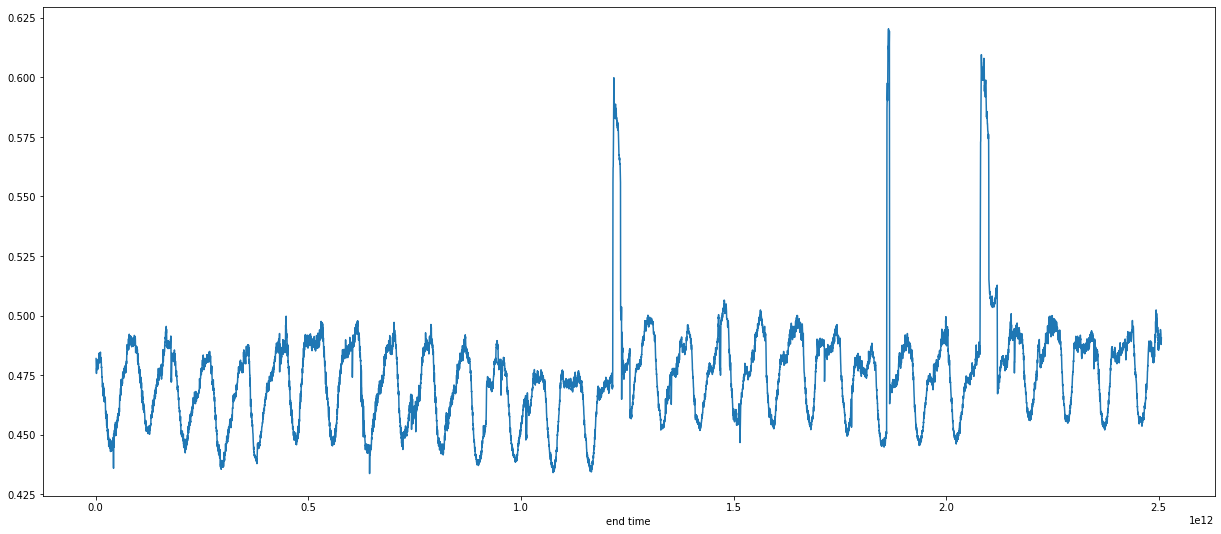

In [11]:
pyplot.figure(figsize=(21, 9))

readings_df_x["Efficiency"]['mean'].plot()

In [12]:
readings_df = readings_df_x[columns_to_consider[1:-1]]
readings_df["Efficiency"] = readings_df_x["Efficiency"]["mean"].values
readings_df

<ipython-input-12-783e881f605a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readings_df["Efficiency"] = readings_df_x["Efficiency"]["mean"].values


CPU rate                                               \
                   mean   median      min      max      q25      q75   
end time                                                               
900000000      0.035042  0.03528  0.02972  0.03900  0.03406  0.03674   
1200000000     0.033072  0.03326  0.02786  0.03711  0.03149  0.03491   
1500000000     0.032797  0.03284  0.02838  0.03650  0.03131  0.03455   
1800000000     0.032152  0.03198  0.02753  0.03717  0.03064  0.03363   
2100000000     0.032904  0.03235  0.02805  0.03796  0.03174  0.03424   
...                 ...      ...      ...      ...      ...      ...   
2505000000000  0.037400  0.03735  0.03320  0.04242  0.03577  0.03906   
2505300000000  0.036892  0.03687  0.03253  0.04059  0.03485  0.03864   
2505600000000  0.035126  0.03442  0.03107  0.04034  0.03314  0.03687   
2505900000000  0.035702  0.03528  0.03186  0.04419  0.03339  0.03662   
2506200000000  0.036736  0.03644  0.03278  0.04596  0.03436  0.03802   

                                  canonical memory usage           ...  \
                    q95       std                   mean   median  ...   
end time                                                           ...   
900000000      0.038340  0.002287               0.087198  0.08716  ...   
1200000000     0.036512  0.002358               0.086914  0.08691  ...   
1500000000     0.036214  0.002347               0.086879  0.08691  ...   
1800000000     0.035912  0.002360               0.086869  0.08691  ...   
2100000000     0.037402  0.002395               0.087110  0.08704  ...   
...                 ...       ...                    ...      ...  ...   
2505000000000  0.040818  0.002506               0.086642  0.08655  ...   
2505300000000  0.040384  0.002328               0.086651  0.08667  ...   
2505600000000  0.039272  0.002597               0.086642  0.08655  ...   
2505900000000  0.040454  0.002911               0.086642  0.08655  ...   
2506200000000  0.042044  0.003088               0.086642  0.08655  ...   

              cycles per instruction memory accesses per instruction  \
                                 std                            mean   
end time                                                               
900000000                   0.116697                        0.004107   
1200000000                  0.115363                        0.003897   
1500000000                  0.118224                        0.003872   
1800000000                  0.109008                        0.004027   
2100000000                  0.133050                        0.004128   
...                              ...                             ...   
2505000000000               0.098550                        0.003809   
2505300000000               0.099457                        0.003777   
2505600000000               0.124989                        0.003708   
2505900000000               0.133782                        0.003749   
2506200000000               0.131300                        0.003711   

                                                                           \
                 median       min       max       q25       q75       q95   
end time                                                                    
900000000      0.004048  0.003306  0.004837  0.003902  0.004373  0.004750   
1200000000     0.003928  0.003336  0.004458  0.003696  0.004089  0.004434   
1500000000     0.003848  0.003275  0.004565  0.003654  0.004097  0.004468   
1800000000     0.004051  0.003451  0.004576  0.003832  0.004215  0.004500   
2100000000     0.004099  0.003269  0.004864  0.003732  0.004488  0.004728   
...                 ...       ...       ...       ...       ...       ...   
2505000000000  0.003778  0.003233  0.004333  0.003534  0.004131  0.004291   
2505300000000  0.003819  0.003272  0.004504  0.003459  0.004003  0.004219   
2505600000000  0.003671  0.003027  0.004423  0.003369  0.004039  0.004291   
2505900000000  0.003605  0.003186  0

## Other job

In [13]:
other_df = pd.read_csv("/data/cloud_data/Google-clusterdata-2011-2/processed_data/high-level_monitoring/aggregated_multistep_tests/task-usage_job-ID-1699314250_total.csv",
                      header=[0,1], index_col=[0])

In [14]:
other_df_x = other_df.copy()

In [15]:
other_df = other_df_x[columns_to_consider[1:-1]]
other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
other_df

<ipython-input-15-fc0f9ca1119a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values


CPU rate                                               \
                   mean   median      min      max      q25      q75   
end time                                                               
900000000      0.018258  0.01816  0.01521  0.02029  0.01752  0.02011   
1200000000     0.018396  0.01736  0.01505  0.02292  0.01617  0.02048   
1500000000     0.019640  0.02026  0.01520  0.02328  0.01642  0.02304   
1800000000     0.018190  0.01825  0.01497  0.02136  0.01617  0.02020   
2100000000     0.018136  0.01852  0.01512  0.02118  0.01599  0.01987   
...                 ...      ...      ...      ...      ...      ...   
2505000000000  0.015198  0.01663  0.01216  0.01740  0.01274  0.01706   
2505300000000  0.015148  0.01651  0.01131  0.01849  0.01228  0.01715   
2505600000000  0.015598  0.01654  0.01120  0.01733  0.01620  0.01672   
2505900000000  0.017018  0.01678  0.01578  0.01929  0.01636  0.01688   
2506200000000  0.016698  0.01648  0.01477  0.01965  0.01599  0.01660   

                                  canonical memory usage            ...  \
                    q95       std                   mean    median  ...   
end time                                                            ...   
900000000      0.020254  0.002086               0.007208  0.007164  ...   
1200000000     0.022432  0.003242               0.007219  0.007179  ...   
1500000000     0.023232  0.003717               0.007213  0.007172  ...   
1800000000     0.021128  0.002671               0.007205  0.007179  ...   
2100000000     0.020918  0.002555               0.007203  0.007156  ...   
...                 ...       ...                    ...       ...  ...   
2505000000000  0.017332  0.002532               0.006844  0.006828  ...   
2505300000000  0.018222  0.003162               0.006818  0.006821  ...   
2505600000000  0.017208  0.002493               0.006815  0.006828  ...   
2505900000000  0.018808  0.001342               0.006812  0.006828  ...   
2506200000000  0.019040  0.001802               0.006822  0.006828  ...   

              cycles per instruction memory accesses per instruction           \
                                 std                            mean   median   
end time                                                                        
900000000                   0.423815                        0.019064  0.01814   
1200000000                  0.640575                        0.019222  0.01843   
1500000000                  0.943185                        0.019938  0.01757   
1800000000                  0.597821                        0.019478  0.01765   
2100000000                  0.579298                        0.019666  0.01876   
...                              ...                             ...      ...   
2505000000000               0.806429                        0.022696  0.02467   
2505300000000               0.939273                        0.022540  0.02367   
2505600000000               0.917826                        0.023628  0.02557   
2505900000000               0.327821                        0.025762  0.02551   
2506200000000               0.493741                        0.025132  0.02436   

                                                                       \
                   min      max      q25      q75       q95       std   
end time                                                                
900000000      0.01631  0.02274  0.01814  0.01999  0.022190  0.002432   
1200000000     0.01611  0.02537  0.01777  0.01843  0.023982  0.003565   
1500000000     0.01558  0.02607  0.01558  0.02489  0.025834  0.005141   
1800000000     0.01580  0.02454  0.01765  0.02175  0.023982  0.003571   
2100000000     0.01619  0.02468  0.01876  0.01994  0.023732  0.003120   
...                ...      ...      ...      ...       ...       ...   
2505000000000  0.01746  0.02560  0.02078  0.02497  0.025474  0.003485   
2505300000000  0.01601  0.02639  0.02075  0.02588  0.026288  0.004275   
2505600000000  0.

In [16]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [17]:
alignments = []

In [18]:
# alignment = dtw(readings_df.values, readings_df.values, keep_internals=True)

In [19]:
# alignment.distance

In [20]:
from glob import glob

In [21]:
filelist = glob("/data/cloud_data/Google-clusterdata-2011-2/processed_data/high-level_monitoring/aggregated_multistep_tests/*.csv")


In [22]:
len(filelist)

412

Here, we are setting the datetime column as index,as needed by the interpolate function from pandas

Use interpolation to remove nan. Sources:
- https://stackoverflow.com/questions/49308530/missing-values-in-time-series-in-python
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html



In [23]:
for count, f in enumerate(filelist[:]):
    print("%i out of %i" % (count, len(filelist)))
    other_df = pd.read_csv(f, header=[0,1], index_col=[0])
    other_df_x = other_df.copy()
    other_df = other_df_x[columns_to_consider[1:-1]]
    other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
    other_df.reset_index(inplace=True)
    other_df["datetime"] = [
            pd.Timestamp(int(t / 1000000) + 1304233200, tz="US/Pacific", unit="s")
            for t in other_df["end time"].values]

    other_df.set_index("datetime", inplace=True)

    other_df.interpolate(method="time", limit_direction="both", inplace=True)

    other_df.reset_index(inplace=True)

    other_df.drop('datetime', axis=1, inplace=True)

    other_df.set_index("end time", inplace=True)
    
    print(other_df.max())
    alignment = dtw(other_df.values, readings_df.values, keep_internals=True)
    alignments.append(alignment.distance)
    print("\t\talignment distance: %i" %alignment.distance)
    del other_df, alignment

<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values


0 out of 412


<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-23-a1c047191393>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-23-a1c047191393>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

CPU rate                         mean      0.027162
                                 median    0.028690
                                 min       0.022130
                                 max       0.035710
                                 q25       0.023990
                                             ...   
memory accesses per instruction  q25       0.039670
                                 q75       0.042540
                                 q95       0.089490
                                 std       0.037735
Efficiency                                 0.704168
Length: 97, dtype: float64
		alignment distance: 104730
1 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.070780
                                 median    0.070620
                                 min       0.067380
                                 max       0.087520
                                 q25       0.068695
                                             ...   
memory accesses per instruction  q25       0.068580
                                 q75       0.076210
                                 q95       0.081657
                                 std       0.030264
Efficiency                                 2.933259
Length: 97, dtype: float64
		alignment distance: 82658
2 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.005127
                                 median    0.005127
                                 min       0.005127
                                 max       0.008606
                                 q25       0.005127
                                             ...   
memory accesses per instruction  q25       0.050460
                                 q75       0.050460
                                 q95       0.050460
                                 std       0.006984
Efficiency                                 0.109259
Length: 97, dtype: float64
		alignment distance: 15853
3 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.052730
                                 median    0.052730
                                 min       0.052730
                                 max       0.059510
                                 q25       0.052730
                                             ...   
memory accesses per instruction  q25       0.030770
                                 q75       0.030770
                                 q95       0.030770
                                 std       0.017812
Efficiency                                 0.400668
Length: 97, dtype: float64
		alignment distance: 104370
4 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.002389
                                 median    0.002071
                                 min       0.001652
                                 max       0.008041
                                 q25       0.001652
                                             ...   
memory accesses per instruction  q25       0.384200
                                 q75       0.384200
                                 q95       0.384200
                                 std       0.071930
Efficiency                                 0.044501
Length: 97, dtype: float64
		alignment distance: 700626
5 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.004788
                                 median    0.004788
                                 min       0.004082
                                 max       0.005585
                                 q25       0.004389
                                             ...   
memory accesses per instruction  q25       0.030755
                                 q75       0.041582
                                 q95       0.047036
                                 std       0.028176
Efficiency                                 0.397907
Length: 97, dtype: float64
		alignment distance: 155361
6 out of 412
CPU rate                         mean      0.015890
                                 median    0.015890
                                 min       0.000042
                                 max       0.031740
                                 q25       0.007965
                                             ...   
memory accesses per instruction  q25       0.12

<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

		alignment distance: 455967
7 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.012707
                                 median    0.012390
                                 min       0.010880
                                 max       0.025730
                                 q25       0.011300
                                             ...   
memory accesses per instruction  q25       0.053602
                                 q75       0.100700
                                 q95       0.100700
                                 std       0.054384
Efficiency                                 0.442920
Length: 97, dtype: float64
		alignment distance: 14765
8 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.129200
                                 median    0.129200
                                 min       0.129200
                                 max       0.129200
                                 q25       0.129200
                                             ...   
memory accesses per instruction  q25       0.050425
                                 q75       0.056280
                                 q95       0.059040
                                 std       0.020993
Efficiency                                 2.117850
Length: 97, dtype: float64
		alignment distance: 278207
9 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.007805
                                 median    0.007744
                                 min       0.007538
                                 max       0.008133
                                 q25       0.007641
                                             ...   
memory accesses per instruction  q25       0.024725
                                 q75       0.029755
                                 q95       0.031020
                                 std       0.011484
Efficiency                                 0.788734
Length: 97, dtype: float64
		alignment distance: 95472
10 out of 412
CPU rate                         mean      0.002722
                                 median    0.002722
                                 min       0.000041
                                 max       0.005409
                                 q25       0.001378
                                             ...   
memory accesses per instruction  q25       0.11

<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

		alignment distance: 479131
11 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.146500
                                 median    0.146500
                                 min       0.146500
                                 max       0.213600
                                 q25       0.146500
                                             ...   
memory accesses per instruction  q25       0.002221
                                 q75       0.002221
                                 q95       0.002221
                                 std       0.000904
Efficiency                                 0.815917
Length: 97, dtype: float64
		alignment distance: 32919
12 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.220950
                                 median    0.220950
                                 min       0.209000
                                 max       0.271000
                                 q25       0.214375
                                             ...   
memory accesses per instruction  q25       0.032177
                                 q75       0.033708
                                 q95       0.038487
                                 std       0.028604
Efficiency                                 0.534167
Length: 97, dtype: float64
		alignment distance: 54696
13 out of 412
CPU rate                         mean      0.005447
                                 median    0.005447
                                 min       0.005447
                                 max       0.005447
                                 q25       0.005447
                                             ...   
memory accesses per instruction  q25       0.10

<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

		alignment distance: 556748
14 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.009107
                                 median    0.009107
                                 min       0.005356
                                 max       0.016970
                                 q25       0.005356
                                             ...   
memory accesses per instruction  q25       0.033548
                                 q75       0.054362
                                 q95       0.062689
                                 std       0.031758
Efficiency                                 0.126917
Length: 97, dtype: float64
		alignment distance: 88829
15 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.023932
                                 median    0.023932
                                 min       0.000690
                                 max       0.047670
                                 q25       0.012063
                                             ...   
memory accesses per instruction  q25       0.066335
                                 q75       0.072620
                                 q95       0.076388
                                 std       0.042410
Efficiency                                 0.226644
Length: 97, dtype: float64
		alignment distance: 215159
16 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.029585
                                 median    0.030500
                                 min       0.023800
                                 max       0.039250
                                 q25       0.028168
                                             ...   
memory accesses per instruction  q25       0.107785
                                 q75       0.122500
                                 q95       0.123135
                                 std       0.055172
Efficiency                                 0.380896
Length: 97, dtype: float64
		alignment distance: 392409
17 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.003124
                                 median    0.003124
                                 min       0.003124
                                 max       0.008301
                                 q25       0.003124
                                             ...   
memory accesses per instruction  q25       0.161000
                                 q75       0.161000
                                 q95       0.161000
                                 std       0.071559
Efficiency                                 0.019075
Length: 97, dtype: float64
		alignment distance: 687944
18 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.081540
                                 median    0.081540
                                 min       0.081540
                                 max       0.145500
                                 q25       0.081540
                                             ...   
memory accesses per instruction  q25       0.018040
                                 q75       0.018040
                                 q95       0.018040
                                 std       0.001377
Efficiency                                 1.853622
Length: 97, dtype: float64
		alignment distance: 29704
19 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.014373
                                 median    0.014374
                                 min       0.005745
                                 max       0.023010
                                 q25       0.010055
                                             ...   
memory accesses per instruction  q25       0.020628
                                 q75       0.021243
                                 q95       0.021673
                                 std       0.010469
Efficiency                                 0.457880
Length: 97, dtype: float64
		alignment distance: 10493
20 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.054015
                                 median    0.053710
                                 min       0.050420
                                 max       0.848600
                                 q25       0.052490
                                             ...   
memory accesses per instruction  q25       0.000261
                                 q75       0.000293
                                 q95       0.000370
                                 std       0.003998
Efficiency                                 0.760520
Length: 97, dtype: float64
		alignment distance: 49358
21 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.043467
                                 median    0.043550
                                 min       0.034120
                                 max       0.110700
                                 q25       0.040935
                                             ...   
memory accesses per instruction  q25       0.013055
                                 q75       0.015422
                                 q95       0.016686
                                 std       0.005746
Efficiency                                 0.332579
Length: 97, dtype: float64
		alignment distance: 71229
22 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.021521
                                 median    0.021521
                                 min       0.006859
                                 max       0.038450
                                 q25       0.013057
                                             ...   
memory accesses per instruction  q25       0.049103
                                 q75       0.049827
                                 q95       0.050117
                                 std       0.011985
Efficiency                                 0.473213
Length: 97, dtype: float64
		alignment distance: 15004
23 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.167850
                                 median    0.167850
                                 min       0.151100
                                 max       0.251500
                                 q25       0.156575
                                             ...   
memory accesses per instruction  q25       0.016290
                                 q75       0.036785
                                 q95       0.063437
                                 std       0.029603
Efficiency                                 0.760056
Length: 97, dtype: float64
		alignment distance: 41813
24 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.017639
                                 median    0.017235
                                 min       0.003040
                                 max       0.041200
                                 q25       0.012395
                                             ...   
memory accesses per instruction  q25       0.068520
                                 q75       0.112875
                                 q95       0.135800
                                 std       0.049105
Efficiency                                 2.050605
Length: 97, dtype: float64
		alignment distance: 243242
25 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.023173
                                 median    0.020600
                                 min       0.018590
                                 max       0.128400
                                 q25       0.019777
                                             ...   
memory accesses per instruction  q25       0.000256
                                 q75       0.036623
                                 q95       0.039255
                                 std       0.018031
Efficiency                                 0.105508
Length: 97, dtype: float64
		alignment distance: 49935
26 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.021909
                                 median    0.021909
                                 min       0.003159
                                 max       0.043150
                                 q25       0.011289
                                             ...   
memory accesses per instruction  q25       0.073548
                                 q75       0.114623
                                 q95       0.131965
                                 std       0.072411
Efficiency                                 0.460718
Length: 97, dtype: float64
		alignment distance: 46479
27 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.051818
                                 median    0.050540
                                 min       0.044130
                                 max       0.157200
                                 q25       0.046630
                                             ...   
memory accesses per instruction  q25       0.018260
                                 q75       0.018260
                                 q95       0.018260
                                 std       0.001853
Efficiency                                 0.803981
Length: 97, dtype: float64
		alignment distance: 26101
28 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.012190
                                 median    0.012190
                                 min       0.008118
                                 max       0.016690
                                 q25       0.009956
                                             ...   
memory accesses per instruction  q25       0.038852
                                 q75       0.040517
                                 q95       0.042743
                                 std       0.022917
Efficiency                                 0.143059
Length: 97, dtype: float64
		alignment distance: 96460
29 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.155000
                                 median    0.155000
                                 min       0.155000
                                 max       0.155000
                                 q25       0.155000
                                             ...   
memory accesses per instruction  q25       0.113300
                                 q75       0.113300
                                 q95       0.113300
                                 std       0.004304
Efficiency                                 0.976317
Length: 97, dtype: float64
		alignment distance: 62535
30 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.043404
                                 median    0.042720
                                 min       0.037540
                                 max       0.051760
                                 q25       0.040130
                                             ...   
memory accesses per instruction  q25       0.026620
                                 q75       0.028250
                                 q95       0.029075
                                 std       0.006772
Efficiency                                 0.345069
Length: 97, dtype: float64
		alignment distance: 110316
31 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.433309
                                 median    0.438250
                                 min       0.392600
                                 max       0.532200
                                 q25       0.433600
                                             ...   
memory accesses per instruction  q25       0.021653
                                 q75       0.037248
                                 q95       0.054530
                                 std       0.014680
Efficiency                                 2.732330
Length: 97, dtype: float64
		alignment distance: 26677
32 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.003982
                                 median    0.003982
                                 min       0.003792
                                 max       0.004959
                                 q25       0.003887
                                             ...   
memory accesses per instruction  q25       0.016701
                                 q75       0.035714
                                 q95       0.043319
                                 std       0.026888
Efficiency                                 0.265368
Length: 97, dtype: float64
		alignment distance: 31087
33 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.591800
                                 median    0.591800
                                 min       0.591800
                                 max       0.591800
                                 q25       0.591800
                                             ...   
memory accesses per instruction  q25       0.142900
                                 q75       0.154900
                                 q95       0.161800
                                 std       0.062761
Efficiency                                 2.718751
Length: 97, dtype: float64
		alignment distance: 14296
34 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.016691
                                 median    0.016691
                                 min       0.004433
                                 max       0.031800
                                 q25       0.009136
                                             ...   
memory accesses per instruction  q25       0.047385
                                 q75       0.071214
                                 q95       0.088307
                                 std       0.060433
Efficiency                                 0.469746
Length: 97, dtype: float64
		alignment distance: 34787
35 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.351100
                                 median    0.351100
                                 min       0.351100
                                 max       0.362300
                                 q25       0.351100
                                             ...   
memory accesses per instruction  q25       0.055840
                                 q75       0.055840
                                 q95       0.055840
                                 std       0.017031
Efficiency                                 2.006336
Length: 97, dtype: float64
		alignment distance: 23243
36 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.002706
                                 median    0.002706
                                 min       0.001894
                                 max       0.004189
                                 q25       0.002224
                                             ...   
memory accesses per instruction  q25       0.033300
                                 q75       0.034292
                                 q95       0.040722
                                 std       0.022992
Efficiency                                 0.319236
Length: 97, dtype: float64
		alignment distance: 61977
37 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.000438
                                 median    0.000438
                                 min       0.000190
                                 max       0.000755
                                 q25       0.000279
                                             ...   
memory accesses per instruction  q25       0.073516
                                 q75       0.125477
                                 q95       0.148295
                                 std       0.084011
Efficiency                                 0.044851
Length: 97, dtype: float64
		alignment distance: 192438
38 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.182833
                                 median    0.183300
                                 min       0.181600
                                 max       0.183600
                                 q25       0.182450
                                             ...   
memory accesses per instruction  q25       0.015370
                                 q75       0.016700
                                 q95       0.017276
                                 std       0.005252
Efficiency                                 3.944833
Length: 97, dtype: float64
		alignment distance: 51686
39 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.026915
                                 median    0.026915
                                 min       0.026550
                                 max       0.027280
                                 q25       0.026732
                                             ...   
memory accesses per instruction  q25       0.033258
                                 q75       0.071626
                                 q95       0.089133
                                 std       0.061898
Efficiency                                 0.418303
Length: 97, dtype: float64
		alignment distance: 16911
40 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.004112
                                 median    0.004112
                                 min       0.004112
                                 max       0.008347
                                 q25       0.004112
                                             ...   
memory accesses per instruction  q25       0.131500
                                 q75       0.140900
                                 q95       0.145710
                                 std       0.069073
Efficiency                                 0.621799
Length: 97, dtype: float64
		alignment distance: 224791
41 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.004601
                                 median    0.003788
                                 min       0.002739
                                 max       0.011170
                                 q25       0.003263
                                             ...   
memory accesses per instruction  q25       0.085630
                                 q75       0.090250
                                 q95       0.092516
                                 std       0.056017
Efficiency                                 0.442574
Length: 97, dtype: float64
		alignment distance: 388767
42 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.019474
                                 median    0.013850
                                 min       0.012680
                                 max       0.041630
                                 q25       0.013265
                                             ...   
memory accesses per instruction  q25       0.034910
                                 q75       0.042790
                                 q95       0.047268
                                 std       0.019795
Efficiency                                 4.533626
Length: 97, dtype: float64
		alignment distance: 72832
43 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.502000
                                 median    0.502000
                                 min       0.502000
                                 max       0.502000
                                 q25       0.502000
                                             ...   
memory accesses per instruction  q25       0.085650
                                 q75       0.085650
                                 q95       0.085650
                                 std       0.009996
Efficiency                                 2.333902
Length: 97, dtype: float64
		alignment distance: 108019
44 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.435959
                                 median    0.444600
                                 min       0.362800
                                 max       0.536100
                                 q25       0.419925
                                             ...   
memory accesses per instruction  q25       0.021855
                                 q75       0.035407
                                 q95       0.046773
                                 std       0.017637
Efficiency                                 3.769390
Length: 97, dtype: float64
		alignment distance: 30305
45 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      1.207000
                                 median    1.207000
                                 min       1.207000
                                 max       1.207000
                                 q25       1.207000
                                             ...   
memory accesses per instruction  q25       0.220300
                                 q75       0.220300
                                 q95       0.220300
                                 std       0.146066
Efficiency                                 1.873769
Length: 97, dtype: float64
		alignment distance: 337101
46 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.111857
                                 median    0.113300
                                 min       0.099980
                                 max       0.123900
                                 q25       0.107200
                                             ...   
memory accesses per instruction  q25       0.005097
                                 q75       0.005583
                                 q95       0.069490
                                 std       0.027078
Efficiency                                 0.620370
Length: 97, dtype: float64
		alignment distance: 403
47 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.053834
                                 median    0.054200
                                 min       0.047120
                                 max       0.059330
                                 q25       0.051150
                                             ...   
memory accesses per instruction  q25       0.007880
                                 q75       0.035610
                                 q95       0.044943
                                 std       0.021400
Efficiency                                 4.242120
Length: 97, dtype: float64
		alignment distance: 57231
48 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.012940
                                 median    0.012940
                                 min       0.012940
                                 max       0.012940
                                 q25       0.012940
                                             ...   
memory accesses per instruction  q25       0.106200
                                 q75       0.116150
                                 q95       0.119630
                                 std       0.044229
Efficiency                                 0.451993
Length: 97, dtype: float64
		alignment distance: 287057
49 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.004412
                                 median    0.004412
                                 min       0.001062
                                 max       0.007950
                                 q25       0.002643
                                             ...   
memory accesses per instruction  q25       0.058408
                                 q75       0.069892
                                 q95       0.085552
                                 std       0.058379
Efficiency                                 0.444563
Length: 97, dtype: float64
		alignment distance: 57533
50 out of 412


<ipython-input-23-a1c047191393>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-23-a1c047191393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-23-a1c047191393>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

CPU rate                         mean      0.166300
                                 median    0.166300
                                 min       0.166300
                                 max       0.166300
                                 q25       0.166300
                                             ...   
memory accesses per instruction  q25       0.128900
                                 q75       0.128900
                                 q95       0.128900
                                 std       0.027004
Efficiency                                 1.415388
Length: 97, dtype: float64


KeyboardInterrupt: 

In [25]:
import pickle

with open("alignemnts_411", "wb") as fp:   #Pickling
    pickle.dump(alignments, fp)

In [26]:
with open('alignemnts_197', 'rb') as fp:
    alignments_old = pickle.load(fp)

In [27]:
alignments_total = alignments_old + alignments 

In [28]:
len(alignments_total)

247

In [29]:
alignments_total

[104730.10305367924,
 82658.0453145892,
 15853.34086667577,
 104370.306257365,
 700626.1493983946,
 155361.3914993707,
 455967.25307052495,
 14765.162225053704,
 278207.5858835146,
 95472.238828468,
 479131.9321581071,
 32919.802762147214,
 54696.167560119626,
 556748.2008355876,
 88829.46455418026,
 215159.28776240966,
 392409.7715212059,
 687944.0098444532,
 29704.135277325324,
 10493.617307466297,
 49358.30828834869,
 71229.467257853,
 15004.783831416853,
 41813.127763191944,
 243242.087802256,
 49935.539544603926,
 46479.431157515595,
 26101.147680562503,
 96460.06854412996,
 62535.27630132598,
 110316.7183666766,
 26677.19724411146,
 31087.81305536718,
 14296.080670931711,
 34787.93827134994,
 23243.96798521821,
 61977.36288643743,
 192438.09162768244,
 51686.41179284538,
 16911.956043415812,
 224791.66233213904,
 388767.6805593009,
 72832.65858490959,
 108019.93149776707,
 30305.33115404839,
 337101.7634649163,
 403.10488389487176,
 57231.22287644297,
 287057.7583311061,
 57533.0

### normalize dynamic time warp distance

In [30]:
max_values = []

for count, f in enumerate(filelist[:]):
    print("%i out of %i" % (count, len(filelist)))
    other_df = pd.read_csv(f, header=[0,1], index_col=[0])
    other_df_x = other_df.copy()
    other_df = other_df_x[columns_to_consider[1:-1]]
    other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
    other_df.reset_index(inplace=True)
    other_df["datetime"] = [
            pd.Timestamp(int(t / 1000000) + 1304233200, tz="US/Pacific", unit="s")
            for t in other_df["end time"].values]

    other_df.set_index("datetime", inplace=True)

    other_df.interpolate(method="time", limit_direction="both", inplace=True)

    other_df.reset_index(inplace=True)

    other_df.drop('datetime', axis=1, inplace=True)

    other_df.set_index("end time", inplace=True)
    
    max_values.append(other_df.max().values)
#    alignment = dtw(other_df.values, readings_df.values, keep_internals=True)
#    alignments.append(alignment.distance)
#    print("\t\talignment distance: %i" %alignment.distance)
#    del other_df, alignment

0 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

1 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

2 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

3 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

4 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

5 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

6 out of 412
7 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

8 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

9 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

10 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

11 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

12 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

13 out of 412
14 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

15 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

16 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

17 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

18 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

19 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

20 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

21 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

22 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

23 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

24 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

25 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

26 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

27 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

28 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

29 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

30 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

31 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

32 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

33 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

34 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

35 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

36 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

37 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

38 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

39 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

40 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

41 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

42 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

43 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

44 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

45 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

46 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

47 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

48 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

49 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

50 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

51 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

52 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

53 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

54 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

55 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

56 out of 412
57 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

58 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

59 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

60 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

61 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

62 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

63 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

64 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

65 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

66 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

67 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

68 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

69 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

70 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

71 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

72 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

73 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

74 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

75 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

76 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

77 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

78 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

79 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

80 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

81 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

82 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

83 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

84 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

85 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

86 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

87 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

88 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

89 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

90 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

91 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

92 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

93 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

94 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

95 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

96 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

97 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

98 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

99 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

100 out of 412
101 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

102 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

103 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

104 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

105 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

106 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

107 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

108 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

109 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

110 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

111 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

112 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

113 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

114 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

115 out of 412
116 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

117 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

118 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

119 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

120 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

121 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

122 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

123 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

124 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

125 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

126 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

127 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

128 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

129 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

130 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

131 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

132 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

133 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

134 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

135 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

136 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

137 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

138 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

139 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

140 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

141 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

142 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

143 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

144 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

145 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

146 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

147 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

148 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

149 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

150 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

151 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

152 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

153 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

154 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

155 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

156 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

157 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

158 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

159 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

160 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

161 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

162 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

163 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

164 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

165 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

166 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

167 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

168 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

169 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

170 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

171 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

172 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

173 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

174 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

175 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

176 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

177 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

178 out of 412


<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

179 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

180 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

181 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

182 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

183 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

184 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

185 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

186 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

187 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

188 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

189 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

190 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

191 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

192 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

193 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

194 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

195 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

196 out of 412


<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-30-4d0d8a39cb90>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

197 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

198 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

199 out of 412
200 out of 412


<ipython-input-30-4d0d8a39cb90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-30-4d0d8a39cb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-30-4d0d8a39cb90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [31]:
max_values

[array([2.71620000e-02, 2.86900000e-02, 2.21300000e-02, 3.57100000e-02,
        2.39900000e-02, 3.05800000e-02, 3.43480000e-02, 8.71206319e-03,
        1.30820000e-02, 1.31100000e-02, 1.24700000e-02, 1.41400000e-02,
        1.28000000e-02, 1.34900000e-02, 1.40100000e-02, 2.77510552e-03,
        1.75040000e-02, 1.74600000e-02, 1.70300000e-02, 1.86200000e-02,
        1.72100000e-02, 1.78800000e-02, 1.83500000e-02, 4.41554300e-03,
        8.73400000e-03, 8.82000000e-03, 8.39200000e-03, 9.55200000e-03,
        8.53000000e-03, 9.04800000e-03, 9.35340000e-03, 2.48371617e-03,
        9.14620000e-03, 9.24700000e-03, 8.77400000e-03, 9.90300000e-03,
        8.95700000e-03, 9.49100000e-03, 9.70740000e-03, 2.48248589e-03,
        2.38900000e-02, 2.39000000e-02, 2.31900000e-02, 2.46900000e-02,
        2.38000000e-02, 2.43200000e-02, 2.45500000e-02, 8.89365493e-03,
        3.23260000e-03, 3.39500000e-03, 2.66300000e-03, 4.46300000e-03,
        3.13200000e-03, 3.66600000e-03, 4.13880000e-03, 1.145646

In [32]:
max_df = pd.DataFrame(max_values, columns=other_df.columns)

In [33]:
max_df.max()

CPU rate                         mean      12.580000
                                 median    12.580000
                                 min       12.580000
                                 max       64.620000
                                 q25       12.580000
                                             ...    
memory accesses per instruction  q25        0.384600
                                 q75        0.401029
                                 q95        0.506046
                                 std        0.372556
Efficiency                                 33.735713
Length: 97, dtype: float64

In [36]:
for count, f in enumerate(filelist[:]):
    print("%i out of %i" % (count, len(filelist)))
    other_df = pd.read_csv(f, header=[0,1], index_col=[0])
    other_df_x = other_df.copy()
    other_df = other_df_x[columns_to_consider[1:-1]]
    other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
    other_df.reset_index(inplace=True)
    other_df["datetime"] = [
            pd.Timestamp(int(t / 1000000) + 1304233200, tz="US/Pacific", unit="s")
            for t in other_df["end time"].values]

    other_df.set_index("datetime", inplace=True)

    other_df.interpolate(method="time", limit_direction="both", inplace=True)

    other_df.reset_index(inplace=True)

    other_df.drop('datetime', axis=1, inplace=True)

    other_df.set_index("end time", inplace=True)
        
    print(len(other_df))
#    alignment = dtw(other_df.values, readings_df.values, keep_internals=True)
#    alignments.append(alignment.distance)
#    print("\t\talignment distance: %i" %alignment.distance)
#    del other_df, alignment

0 out of 412
8352
1 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
2 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

11133
3 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8902
4 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

13675
5 out of 412
8352
6 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
7 out of 412
8352
8 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8360
9 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8357
10 out of 412
8352
11 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

17248
12 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
13 out of 412
8345
14 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
15 out of 412
8352
16 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
17 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

13470
18 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8397
19 out of 412
8351
20 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
21 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
22 out of 412
8352
23 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
24 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8353
25 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
26 out of 412
8351
27 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8394
28 out of 412
8351
29 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8406
30 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
31 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
32 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8437
33 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8833
34 out of 412
8352
35 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9595
36 out of 412
8352
37 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8407
38 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8348
39 out of 412
8352
40 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8382
41 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8362
42 out of 412
8351
43 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

29288
44 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
45 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

70474
46 out of 412
8352
47 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
48 out of 412
8368
49 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
50 out of 412
8416
51 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8386
52 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

85551
53 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
54 out of 412
8351
55 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8842
56 out of 412
8351
57 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
58 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8403
59 out of 412
8352
60 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
61 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

10402
62 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8361
63 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8386
64 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
65 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8403
66 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
67 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
68 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8430
69 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
70 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8654
71 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8458
72 out of 412
8352
73 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8353
74 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
75 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
76 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
77 out of 412
8433
78 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8401
79 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8404
80 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
81 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
82 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8756
83 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
84 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8339
85 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
86 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8410
87 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
88 out of 412
8351
89 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
90 out of 412
8352
91 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

10723
92 out of 412
8351
93 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
94 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8399
95 out of 412
8352
96 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
97 out of 412
8360
98 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8356
99 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

19382
100 out of 412
8352
101 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
102 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
103 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

10215
104 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8367
105 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
106 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8330
107 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8574
108 out of 412
8352
109 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
110 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
111 out of 412
8351
112 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8390
113 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

9144
114 out of 412
8352
115 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8324
116 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
117 out of 412
8459
118 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8351
119 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

10913
120 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8396
121 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9189
122 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
123 out of 412
8352
124 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
125 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8687
126 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8407
127 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8361
128 out of 412
8352
129 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
130 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

18344
131 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
132 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
133 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
134 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8353
135 out of 412
8352
136 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8391
137 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
138 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
139 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8497
140 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
141 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
142 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
143 out of 412
8352
144 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
145 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
146 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
147 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8367
148 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8535
149 out of 412
8352
150 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
151 out of 412
8353
152 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
153 out of 412
8352
154 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

17097
155 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
156 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
157 out of 412
8386
158 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8359
159 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

16428
160 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
161 out of 412
8352
162 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8508
163 out of 412
8418
164 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

11273
165 out of 412
8358
166 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

10448
167 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8569
168 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

9223
169 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
170 out of 412
8350
171 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
172 out of 412
8351
173 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8840
174 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
175 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8486
176 out of 412
8351
177 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
178 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8393
179 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
180 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
181 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8354
182 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8368
183 out of 412
8383
184 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
185 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8350
186 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
187 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
188 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8372
189 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8408
190 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8378
191 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
192 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8356
193 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8426
194 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8381
195 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
196 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8354
197 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

609703
198 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8353
199 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
200 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8395
201 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
202 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
203 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
204 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
205 out of 412
8415
206 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
207 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8365
208 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
209 out of 412
8352
210 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
211 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
212 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
213 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8357
214 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8426
215 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8373
216 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8385
217 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
218 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
219 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8353
220 out of 412
8289
221 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
222 out of 412
8358
223 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8906
224 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8357
225 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
226 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8338
227 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8430
228 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
229 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9591
230 out of 412
8365
231 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8387
232 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
233 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8335
234 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
235 out of 412
8337
236 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8349
237 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

9210
238 out of 412
8352
239 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8530
240 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8369
241 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
242 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8510
243 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8378
244 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
245 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
246 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
247 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
248 out of 412
8352
249 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
250 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
251 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
252 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
253 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8370
254 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

20618
255 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8388
256 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8437
257 out of 412
8302
258 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8318
259 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
260 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

13491
261 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

20369
262 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8353
263 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
264 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8436
265 out of 412
8358
266 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8435
267 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8491
268 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
269 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

9022
270 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8566
271 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
272 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8416
273 out of 412
8587
274 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
275 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8394
276 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8365
277 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8642
278 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

13971
279 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8453
280 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
281 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8642
282 out of 412
8354
283 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
284 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8804
285 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
286 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
287 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8369
288 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8351
289 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9213
290 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
291 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
292 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8354
293 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
294 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
295 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
296 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
297 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
298 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
299 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
300 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8353
301 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8372
302 out of 412
8352
303 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
304 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8371
305 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
306 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8371
307 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
308 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
309 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
310 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
311 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8363
312 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8745
313 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
314 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8465
315 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

13845
316 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9290
317 out of 412
8350
318 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
319 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
320 out of 412
8352
321 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
322 out of 412
8351
323 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
324 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8411
325 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

31265
326 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
327 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
328 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
329 out of 412
8352
330 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
331 out of 412
8352
332 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8429
333 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
334 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

9029
335 out of 412
8351
336 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
337 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
338 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8356
339 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

246329
340 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8360
341 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8404
342 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8285
343 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

39199
344 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8356
345 out of 412
8352
346 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
347 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

10254
348 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9776
349 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

37937
350 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
351 out of 412
8351
352 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8400
353 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
354 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

13672
355 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8351
356 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9603
357 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
358 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8414
359 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
360 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
361 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8355
362 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

9377
363 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
364 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
365 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
366 out of 412
8365
367 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
368 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8669
369 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

9468
370 out of 412
8352
371 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8392
372 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
373 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8793
374 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8367
375 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8433
376 out of 412
8351
377 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
378 out of 412
8352
379 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8485
380 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
381 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
382 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8362
383 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8366
384 out of 412
8352
385 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8350
386 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8427
387 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
388 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8394
389 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
390 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
391 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
392 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8429
393 out of 412


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

8352
394 out of 412
8352
395 out of 412


<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

8352
396 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8351
397 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8585
398 out of 412
8352
399 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8377
400 out of 412
8352
401 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
402 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

10311
403 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
404 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8390
405 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
406 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
407 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
408 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8357
409 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8411
410 out of 412


<ipython-input-36-9312b77c7ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

8352
411 out of 412
8351


<ipython-input-36-9312b77c7ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-36-9312b77c7ba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df.interpolate(method="time", limit_direction="both", inplace=True)
<ipython-input-36-9312b77c7ba6>:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  other_df.drop('datetime', axis=1, inplace=True)
<ipython-input-36-9312b77c7ba6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [37]:
readings_df

CPU rate                                               \
                   mean   median      min      max      q25      q75   
end time                                                               
900000000      0.035042  0.03528  0.02972  0.03900  0.03406  0.03674   
1200000000     0.033072  0.03326  0.02786  0.03711  0.03149  0.03491   
1500000000     0.032797  0.03284  0.02838  0.03650  0.03131  0.03455   
1800000000     0.032152  0.03198  0.02753  0.03717  0.03064  0.03363   
2100000000     0.032904  0.03235  0.02805  0.03796  0.03174  0.03424   
...                 ...      ...      ...      ...      ...      ...   
2505000000000  0.037400  0.03735  0.03320  0.04242  0.03577  0.03906   
2505300000000  0.036892  0.03687  0.03253  0.04059  0.03485  0.03864   
2505600000000  0.035126  0.03442  0.03107  0.04034  0.03314  0.03687   
2505900000000  0.035702  0.03528  0.03186  0.04419  0.03339  0.03662   
2506200000000  0.036736  0.03644  0.03278  0.04596  0.03436  0.03802   

                                  canonical memory usage           ...  \
                    q95       std                   mean   median  ...   
end time                                                           ...   
900000000      0.038340  0.002287               0.087198  0.08716  ...   
1200000000     0.036512  0.002358               0.086914  0.08691  ...   
1500000000     0.036214  0.002347               0.086879  0.08691  ...   
1800000000     0.035912  0.002360               0.086869  0.08691  ...   
2100000000     0.037402  0.002395               0.087110  0.08704  ...   
...                 ...       ...                    ...      ...  ...   
2505000000000  0.040818  0.002506               0.086642  0.08655  ...   
2505300000000  0.040384  0.002328               0.086651  0.08667  ...   
2505600000000  0.039272  0.002597               0.086642  0.08655  ...   
2505900000000  0.040454  0.002911               0.086642  0.08655  ...   
2506200000000  0.042044  0.003088               0.086642  0.08655  ...   

              cycles per instruction memory accesses per instruction  \
                                 std                            mean   
end time                                                               
900000000                   0.116697                        0.004107   
1200000000                  0.115363                        0.003897   
1500000000                  0.118224                        0.003872   
1800000000                  0.109008                        0.004027   
2100000000                  0.133050                        0.004128   
...                              ...                             ...   
2505000000000               0.098550                        0.003809   
2505300000000               0.099457                        0.003777   
2505600000000               0.124989                        0.003708   
2505900000000               0.133782                        0.003749   
2506200000000               0.131300                        0.003711   

                                                                           \
                 median       min       max       q25       q75       q95   
end time                                                                    
900000000      0.004048  0.003306  0.004837  0.003902  0.004373  0.004750   
1200000000     0.003928  0.003336  0.004458  0.003696  0.004089  0.004434   
1500000000     0.003848  0.003275  0.004565  0.003654  0.004097  0.004468   
1800000000     0.004051  0.003451  0.004576  0.003832  0.004215  0.004500   
2100000000     0.004099  0.003269  0.004864  0.003732  0.004488  0.004728   
...                 ...       ...       ...       ...       ...       ...   
2505000000000  0.003778  0.003233  0.004333  0.003534  0.004131  0.004291   
2505300000000  0.003819  0.003272  0.004504  0.003459  0.004003  0.004219   
2505600000000  0.003671  0.003027  0.004423  0.003369  0.004039  0.004291   
2505900000000  0.003605  0.003186  0

In [38]:
m_data = np.zeros(readings_df.values.shape)

In [39]:
m_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
max_max_values = max_df.max().values

for i in range(len(max_max_values)):
    m_data[:,i] = readings_df.values[:, i] * max_max_values[i]

In [41]:
m_distance = dtw(m_data, readings_df.values, keep_internals=True)

In [42]:
m_distance.distance

12574527.520347368

In [43]:
alignments_normalized = alignments / m_distance.distance

In [44]:
alignments_normalized

array([8.32875055e-03, 6.57345138e-03, 1.26075042e-03, 8.30013741e-03,
       5.57178907e-02, 1.23552468e-02, 3.62611838e-02, 1.17421209e-03,
       2.21246950e-02, 7.59251102e-03, 3.81033746e-02, 2.61797532e-03,
       4.34975926e-03, 4.42758744e-02, 7.06423875e-03, 1.71107254e-02,
       3.12067210e-02, 5.47093327e-02, 2.36224663e-03, 8.34513845e-04,
       3.92526146e-03, 5.66458399e-03, 1.19326820e-03, 3.32522456e-03,
       1.93440340e-02, 3.97116627e-03, 3.69631631e-03, 2.07571598e-03,
       7.67106902e-03, 4.97317106e-03, 8.77303089e-03, 2.12152681e-03,
       2.47228478e-03, 1.13690798e-03, 2.76654039e-03, 1.84849633e-03,
       4.92880252e-03, 1.53038030e-02, 4.11040587e-03, 1.34493769e-03,
       1.78767482e-02, 3.09170806e-02, 5.79207914e-03, 8.59037696e-03,
       2.41005725e-03, 2.68083046e-02, 3.20572589e-05, 4.55136169e-03,
       2.28285125e-02, 4.57536432e-03])

In [45]:
m_distance_2 = dtw(np.zeros(readings_df.values.shape), readings_df.values, keep_internals=True)

In [46]:
m_distance_2.distance

78037.61864232433

In [47]:
alignments_normalized_2 = alignments / m_distance_2.distance

In [48]:
alignments_normalized_2

array([1.34204637e+00, 1.05920768e+00, 2.03149983e-01, 1.33743582e+00,
       8.97805650e+00, 1.99085254e+00, 5.84291603e+00, 1.89205700e-01,
       3.56504454e+00, 1.22341302e+00, 6.13975593e+00, 4.21845301e-01,
       7.00894883e-01, 7.13435662e+00, 1.13829030e+00, 2.75712267e+00,
       5.02846932e+00, 8.81554335e+00, 3.80638669e-01, 1.34468702e-01,
       6.32493779e-01, 9.12758084e-01, 1.92276290e-01, 5.35807326e-01,
       3.11698501e+00, 6.39890612e-01, 5.95602890e-01, 3.34468787e-01,
       1.23607140e+00, 8.01347829e-01, 1.41363512e+00, 3.41850478e-01,
       3.98369576e-01, 1.83194732e-01, 4.45784211e-01, 2.97855937e-01,
       7.94198541e-01, 2.46596571e+00, 6.62326871e-01, 2.16715430e-01,
       2.88055513e+00, 4.98179836e+00, 9.33301911e-01, 1.38420333e+00,
       3.88342593e-01, 4.31973411e+00, 5.16552005e-03, 7.33379925e-01,
       3.67845359e+00, 7.37247568e-01])

In [49]:
concat_df = pd.DataFrame()

In [50]:
for count, f in enumerate(filelist[:]):
    if i % 10 == 0:
        print("%i out of %i" % (count, len(filelist)))
    other_df = pd.read_csv(f, header=[0,1], index_col=[0])
    other_df_x = other_df.copy()
    other_df = other_df_x[columns_to_consider[1:-1]]
    other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
    other_df.reset_index(inplace=True)
    other_df["datetime"] = [
            pd.Timestamp(int(t / 1000000) + 1304233200, tz="US/Pacific", unit="s")
            for t in other_df["end time"].values]

    other_df.set_index("datetime", inplace=True)

    other_df.interpolate(method="time", limit_direction="both", inplace=True)

    other_df.reset_index(inplace=True)

    other_df.drop('datetime', axis=1, inplace=True)

    other_df.set_index("end time", inplace=True)
        
    if count == 0:
        concat_df = other_df.copy()
    else:
        pd.concat([s1, s2], ignore_index=True)


<ipython-input-50-7a5525e681ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["Efficiency"] = other_df_x["Efficiency"]["mean"].values
<ipython-input-50-7a5525e681ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["datetime"] = [
<ipython-input-50-7a5525e681ed>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

NameError: name 's1' is not defined

I have to find a way to:
- normalize the dynamic time warping distance
- plot the value distribution of our training set vs the others

In [51]:
concat_df['source'] = ['other'] * concat_df.shape[0]

In [52]:
readings_df_source = readings_df.copy()
readings_df_source['source'] = ['reference'] * readings_df.shape[0]

In [53]:
concat_df = pd.concat([concat_df, readings_df_source], ignore_index=True)

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/seaborn/distributions.py:2294: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


(0.0, 1.0)

<Figure size 1008x720 with 0 Axes>

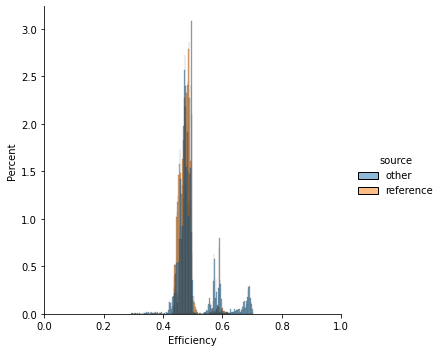

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

sns.displot(data=concat_df, x='Efficiency', hue='source',
            stat='percent')

plt.xlim((0,1))

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/seaborn/distributions.py:2294: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


(0.0, 1.0)

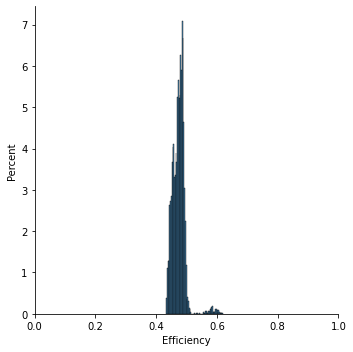

In [55]:
sns.displot(data=readings_df, x='Efficiency', stat='percent')
plt.xlim((0,1))

In [56]:
max_df.mean()[:10]

CPU rate                mean      0.175224
                        median    0.175060
                        min       0.168497
                        max       0.523318
                        q25       0.171794
                        q75       0.178786
                        q95       0.187199
                        std       0.079718
canonical memory usage  mean      0.035325
                        median    0.035570
dtype: float64

In [174]:
index_to_select = [x for x in range(0, 97, 8)] # I am getting just the mean from the dataframe
max_mean = max_df.mean().values
max_mean_mean_values = [max_mean[i] for i in index_to_select]

max_std = max_df.std().values
max_std_mean_values = [max_std[i] for i in index_to_select]


In [58]:
max(readings_mean_mean_values)

NameError: name 'readings_mean_mean_values' is not defined

In [173]:
readings_mean = readings_df.mean().values
readings_mean_mean_values = [readings_mean[i] for i in index_to_select]
readings_std = readings_df.std().values
readings_std_mean_values = [readings_std[i] for i in index_to_select]

In [62]:
len(set(readings_df.columns.get_level_values(0)))

13

In [63]:
len(columns_to_consider)

14

In [64]:
# Import the necessaries libraries
#import plotly.offline as pyo
#import plotly.graph_objs as go
import plotly.graph_objects as go
#pyo.init_notebook_mode()

categories = columns_to_consider[1:]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=max_mean_mean_values,
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      r=readings_mean_mean_values,
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)
import plotly

import plotly.io as pio
pio.orca.config.use_xvfb = True

plotly.io.orca.config.executable = '/opt/anaconda3/envs/neuralnets/bin/orca'

fig.write_image("fig1.png")

In [175]:
max_vals_for_normalization = [max(readings_mean_mean_values[i]+readings_std_mean_values[i], max_mean_mean_values[i] + max_std_mean_values[i]) for i in range(len(max_mean_mean_values))]

In [176]:
max_mean_mean_values_normalized = [max_mean_mean_values[i] / max_vals_for_normalization[i] for i in range(len(max_mean_mean_values))]

In [177]:
readings_mean_mean_values_normalized = [readings_mean_mean_values[i] / max_vals_for_normalization[i] for i in range(len(max_mean_mean_values))]

In [68]:
# Import the necessaries libraries
#import plotly.offline as pyo
#import plotly.graph_objs as go
import plotly.graph_objects as go
#pyo.init_notebook_mode()

categories = columns_to_consider[1:]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=max_mean_mean_values_normalized,
      theta=categories,
      fill='toself',
      name='Test set mean values'
))
fig.add_trace(go.Scatterpolar(
      r=readings_mean_mean_values_normalized,
      theta=categories,
      fill='toself',
      name='Training set mean values'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=1.25,
    xanchor="left",
    x=-0.01,
    font=dict(
        size=14
    )
),height = 500,
                  width =600,
                 )

import plotly


import plotly.io as pio
pio.orca.config.use_xvfb = True

plotly.io.orca.config.executable = '/opt/anaconda3/envs/neuralnets/bin/orca'

fig.write_image("radar_chart.pdf")

In [240]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, *args, **kwargs):
            self.set_thetagrids(np.degrees(theta), labels, *args, **kwargs)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


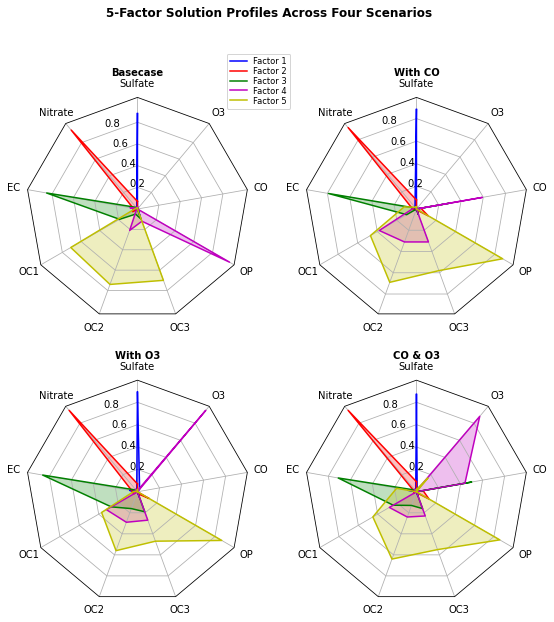

In [167]:
N = 9
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                          labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()


In [191]:
test_plus_std_normalized = [(max_mean_mean_values[i] + max_std_mean_values[i]) / max_vals_for_normalization[i] for i in range(len(max_mean_mean_values))]
test_minus_std_normalized = [(max_mean_mean_values[i] - max_std_mean_values[i]) / max_vals_for_normalization[i] for i in range(len(max_mean_mean_values))]

print(len(test_plus_std_normalized), len(test_minus_std_normalized))

13 13


In [183]:
train_plus_std_normalized = [(readings_mean_mean_values[i] + readings_std_mean_values[i]) / max_vals_for_normalization[i] for i in range(len(max_mean_mean_values))]
train_minus_std_normalized = [(readings_mean_mean_values[i] - readings_std_mean_values[i]) / max_vals_for_normalization[i] for i in range(len(max_mean_mean_values))]



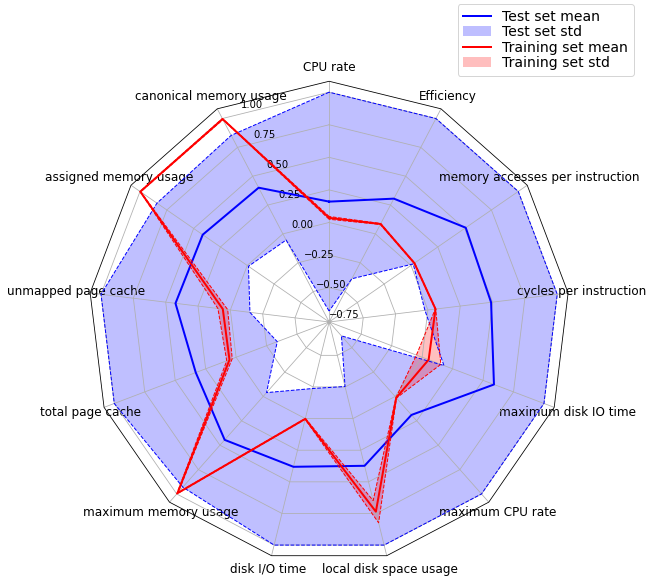

In [259]:
N = 13

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))

theta = radar_factory(N, frame='polygon')
def fill_between(*args, **kwargs):
    """
    Override fill_between 
    - CUSTOM ADDITION TO EXAMPLE - 
    """
    if len(args) and args[0][0] != args[0][-1]:
        args = list(args)
        for i, arg in enumerate(args):
            args[i] = np.append(arg, arg[0])            
                              
    return ax.fill_between(*args, **kwargs)


# Test
ax.plot(theta, test_plus_std_normalized, color='blue', linewidth=1, linestyle='dashed', label='_nolegend_')
ax.plot(theta, max_mean_mean_values_normalized, color='blue', linewidth=2) #, label='_nolegend_')
ax.plot(theta, test_minus_std_normalized, color='blue', linewidth=1, linestyle='dashed', label='_nolegend_')
fill_between(theta, test_plus_std_normalized, test_minus_std_normalized, interpolate=True, facecolor='blue', alpha=0.25)
# Train
ax.plot(theta, train_plus_std_normalized, color='red', linewidth=1, linestyle='dashed', label='_nolegend_')
ax.plot(theta, readings_mean_mean_values_normalized, color='red', linewidth=2) #, label='_nolegend_')
ax.plot(theta, train_minus_std_normalized, color='red', linewidth=1, linestyle='dashed', label='_nolegend_')
fill_between(theta, train_minus_std_normalized, train_plus_std_normalized, facecolor='red', alpha=0.25)




labels = ('Test set mean', 'Test set std', 'Training set mean', 'Training set std')
legend = fig.legend(labels, loc=(0.7, 0.87),
                          labelspacing=0.1, fontsize='14')
ax.set_thetagrids(np.degrees(theta), categories, fontsize=12) 

plt.tight_layout()
plt.savefig('radar_chart_std.pdf')